In [68]:
# conda install pytorch torchvision torchaudio -c pytorch

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# for keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential

# for pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## 1. Loading data

In [10]:
dataset = pd.read_csv('chineseMNIST.csv')
dataset.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九


In [11]:
dataset.info

<bound method DataFrame.info of        pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0            0        0        0        0        0        0        0        0   
1            0        0        0        0        0        0        0        0   
2            0        0        0        0        0        0        0        0   
3            0        0        0        0        0        0        0        0   
4            0        0        0        0        0        0        0        0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14995        0        0        0        0        0        0        0        0   
14996        0        0        0        0        0        0        0        0   
14997        0        0        0        0        0        0        0        0   
14998        0        0        0        0        0        0        0        0   
14999        0        0        0        0        0        0        0        0

This dataset has 4,098 columns.

1) The label is the second from the last column.

2) The last column is the charactor of each Chinese numeral.

4,098 - 2 = 4,096. That means 64 x 64 = 4,096.

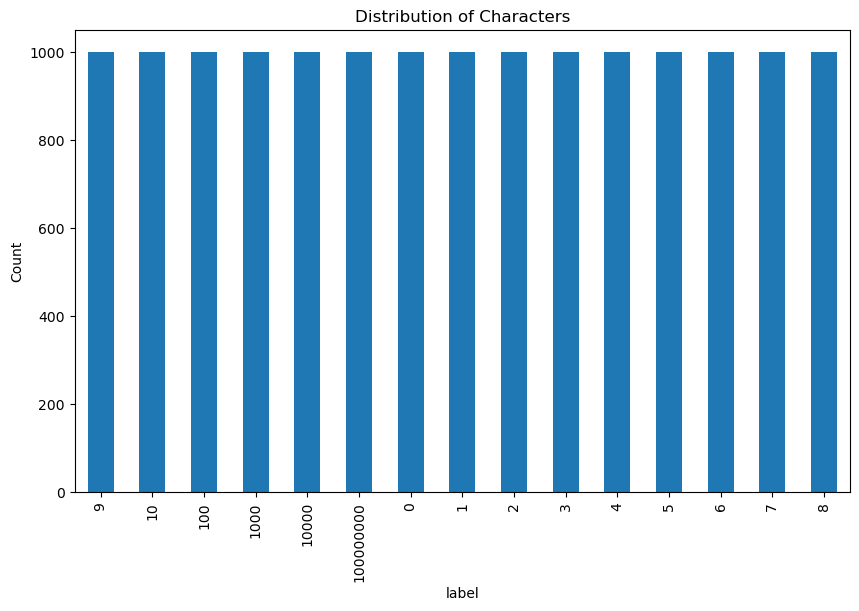

In [27]:
# check the data distribution
character_counts = dataset['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
character_counts.plot(kind='bar')
plt.xlabel('label')
plt.ylabel('Count')
plt.title('Distribution of Characters')
plt.show()

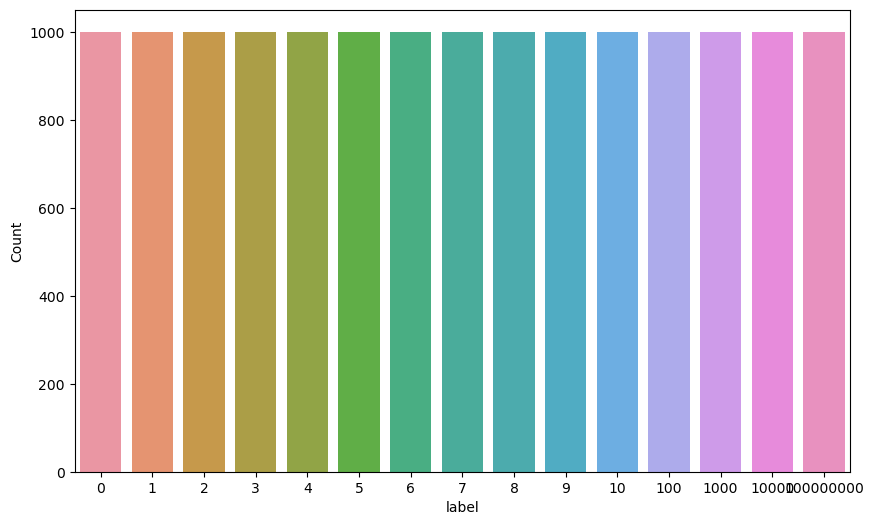

In [67]:
import seaborn as sns

# check the data distribution
character_counts = dataset['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=character_counts.index, y=character_counts.values)
plt.xlabel('label')
plt.ylabel('Count')
plt.show()


So our data is evenly distributed in 15 different labels.

## 2. Feature Engineering - CNN for Keras

In [18]:
#Let's start labelencoding!
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded = le.fit_transform(dataset['character'].values)
decoded = le.inverse_transform(encoded)
dataset['character2'] = encoded
print('This dataset has following true labels, ', le.classes_)

This dataset has following true labels,  ['一' '七' '万' '三' '九' '二' '五' '亿' '八' '六' '十' '千' '四' '百' '零']


In [12]:
# select the data
features = dataset.values[:, :dataset.shape[1]-2]
chars = dataset['character'].values

features.shape, chars.shape

((15000, 4096), (15000,))

In [13]:
# receives data
def process_data(x):
    images = [] # all the images
    # is each row in x, each image
    for img in x:
        # reshape the flatten data
        image = img.reshape(64,64,1)
        images.append(image)
    # return the images in an apropiate format
    return np.array(images).astype('float32')/255

# receives labels
def process_target(chars, num_classes):
    target = [] # is the result
    class_names = {} # other result
    count = count_values(chars) # count the characters
    ###### add the labels for the dict
    for key, i in zip(count.keys(), range(num_classes)):
        class_names[key] = i
    ###### create the labels data, the numbers
    labs = class_names.keys()
    for char in chars:
        pos = class_names[char] # position of the 1
        row = []
        for i in range(num_classes):# create the target [0,0,0...,1,...]
            if pos != i:
                row.append(0)
            else:
                row.append(1)
        target.append(row)
    return np.array(target).astype('float32'), class_names


def count_values(arr):
    dic = {}
    for val in arr:
        if val not in dic.keys():
            dic[val] = 1
        else:
            dic[val] += 1
    return dic

# get the images from the df as arrays
X = process_data(features)

# and obtain the target data from the characters
Y, class_names = process_target(chars, num_classes=15)

X.shape, Y.shape

((15000, 64, 64, 1), (15000, 15))

In [14]:
# split the data, as keras training goes first, for now there won't be val set
x_train_k, x_test_k, y_train_k, y_test_k = train_test_split(X, Y, test_size=.2, random_state=314)
y_train_k.shape, y_test_k.shape

((12000, 15), (3000, 15))

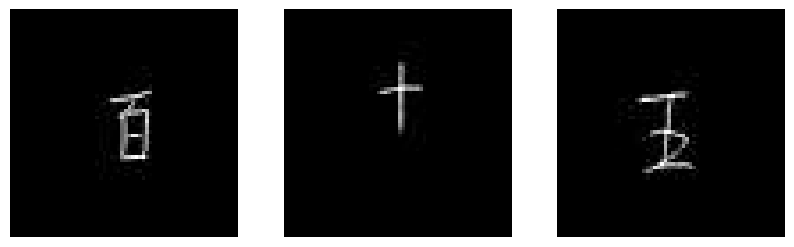

In [23]:
#randomly plot our data
# Assuming 'dataset' is your numpy array with shape (12000, 64, 64, 1)
n_samples = x_train_k.shape[0]
indices = np.random.choice(n_samples, 3, replace=False)

# Plot the randomly selected images
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i, ax in enumerate(axes):
    image = x_train_k[indices[i]].squeeze()  # Remove the last dimension if it's 1
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.show()

It's shown "百", "十","五", which means hundred, ten and five, respectively. 

## 3. CNN - Keras Model Training

In [28]:
#keras.backend.clear_session()

input_shape = (64,64,1) # the dimension of the data
num_classes = 15 # the number of classes

keras_model = Sequential([

    layers.InputLayer(input_shape=input_shape),

    # convolutional part with relu and later pooling
    layers.Conv2D(filters=32, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    # flatten the data, as it comes with (64,64,1) shape
    layers.Flatten(),
    
    # dense part, with neurons
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=.4), # it helps to prevent overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=.4),
    layers.Dense(num_classes, activation='softmax')
])

# compile the model
keras_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy'],
)

keras_hist = keras_model.fit(
    x_train_k,
    y_train_k,
    batch_size=128,
    epochs=20,
    validation_split=.1,# as there's no val data
)


Epoch 1/20
85/85 [==============================] - 7s 78ms/step - loss: 2.1714 - accuracy: 0.2891 - val_loss: 1.1435 - val_accuracy: 0.6517
Epoch 2/20
85/85 [==============================] - 6s 76ms/step - loss: 1.0477 - accuracy: 0.6465 - val_loss: 0.5378 - val_accuracy: 0.8300
Epoch 3/20
85/85 [==============================] - 7s 78ms/step - loss: 0.6059 - accuracy: 0.7916 - val_loss: 0.3606 - val_accuracy: 0.8783
Epoch 4/20
85/85 [==============================] - 6s 76ms/step - loss: 0.4136 - accuracy: 0.8596 - val_loss: 0.2973 - val_accuracy: 0.8950
Epoch 5/20
85/85 [==============================] - 7s 78ms/step - loss: 0.3206 - accuracy: 0.8898 - val_loss: 0.2425 - val_accuracy: 0.9167
Epoch 6/20
85/85 [==============================] - 7s 77ms/step - loss: 0.2346 - accuracy: 0.9206 - val_loss: 0.1908 - val_accuracy: 0.9383
Epoch 7/20
85/85 [==============================] - 7s 82ms/step - loss: 0.2022 - accuracy: 0.9308 - val_loss: 0.1958 - val_accuracy: 0.9300
Epoch 8/20
85

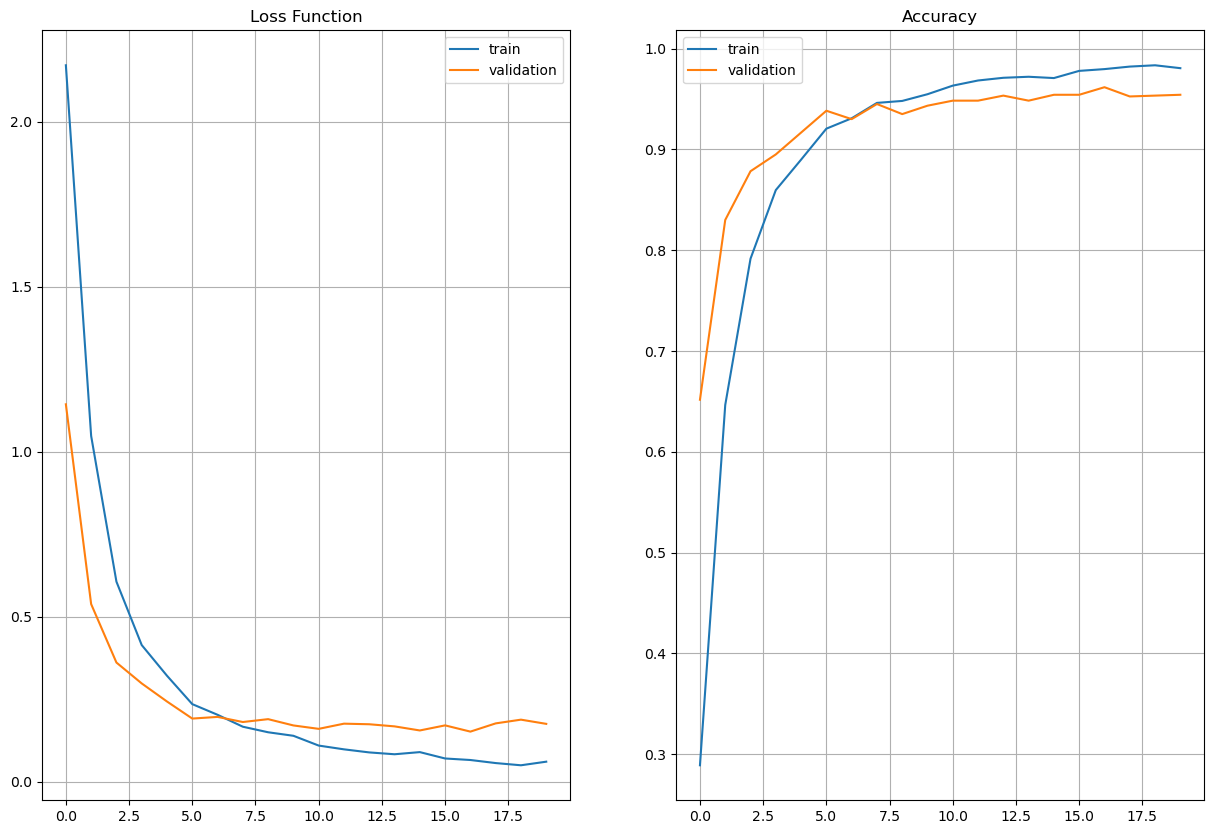

In [29]:
plt.figure(figsize=(15, 10))

# plot the loss function
plt.subplot(1,2,1)
plt.plot(keras_hist.history['loss'], label='train')
plt.plot(keras_hist.history['val_loss'], label='validation')
plt.title('Loss Function')
plt.grid(True)
plt.legend()

# and the accuracy
plt.subplot(1,2,2)
plt.plot(keras_hist.history['accuracy'], label='train')
plt.plot(keras_hist.history['val_accuracy'], label='validation')
plt.grid(True)
plt.title('Accuracy')
plt.legend()

plt.show()

## 4. Feature Engineering - Pytorch for CNN


In [34]:
# First split the data for pytorch
x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(features.astype('float32'), chars, test_size=.2, random_state=314)
x_train_p, x_val_p, y_train_p, y_val_p = train_test_split(x_train_p, y_train_p, test_size=.1, random_state=314)

y_train_p.shape, y_test_p.shape, y_val_p.shape

((10800,), (3000,), (1200,))

In [35]:
class CustomDataset(Dataset):
    # data will be a numpy array, in this case: features
    # labels will be tha characters, in this case: labels

    ######################### THE "BASIC" NEEDED FUNCTIONS
    
    def __init__(self, data, labels, labels_ids=[]):
        # process the labels and the data
        self.process_data(data)
        self.process_labels(labels, labels_ids) # this labels ids is too important, so
                                                # read bellow why and check the function
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels_n[idx]
    
    ######################### THE PROCESSING FUNCTIONS
    
    # function inside the class for process the data
    def process_data(self, data):
        # convert data to a torch tensor
        self.data = torch.from_numpy(data)
        # normalize the data
        self.data = self.data/255
        # reshape the tensor, keep the batch and chanel dim and reshape the images
        self.data = self.data.view(self.data.shape[0], 1, 64, 64)
        
    # function inside the class for process the target
    def process_labels(self, labels, labels_ids):
        # count all the different values in labels
        self.distrib, self.num_labels = self.__count_values(labels)
        
        # verify if there are existant ids !important
        if labels_ids == []:
            # set an id for each label if there's no labels
            self.id_labels = {}
            for label, i in zip(self.distrib.keys(), range(self.num_labels)):
                self.id_labels[label] = i

        # if there are existant labels use them
        else:
            self.id_labels = labels_ids   
            
        # then create an array with the ids
        ids = [] # will be converted in an array
        for label in labels:
            # append the id of the label
            ids.append(self.id_labels[label])
        # use one hot encoding for the labels
        self.labels = []
        self.labels_n = [] # labels without encoding
        for i in ids:
            # append the normal label
            self.labels_n.append(i)
            # append the one hot encoded label
            self.labels.append(self.__one_hot(i))
        # convert to a numpy array, this is because the final dtype
        # was torch.float64 and the data is torch.float32
        self.labels = np.array(self.labels).astype('float32')
        # and convert to torch tensor
        self.labels = torch.from_numpy(self.labels)
        self.labels_n = torch.tensor(self.labels_n, dtype=torch.int64)
        
    
    ######################### EXTRA FUNCTIONS
    
    # extra function to count the different items from an array
    def __count_values(self, arr):
        dic = {}
        for val in arr:
            if val not in dic.keys():
                dic[val] = 1
            else:
                dic[val] += 1
        return dic, len(dic.keys())
    
    # extra function to make one hot encoding for the labels
    def __one_hot(self, label):
        res = np.zeros((self.num_labels))
        res[label]+=1
        return res
    
    # extra function to decode from one hot to numbers
    def decode(self, labels): # recieve a torch tensor, a prediction
        # select the indexs of the max elements in each label
        decoded = torch.argmax(labels, dim=1).numpy()
        return decoded
        
        

#### DATASET CLASS ATRIBUTES: (the ones I use)
# data: all the tensors (images) with shape (bacth,1,64,64), pytorch tensor
# labels: all the labels encoded with one hot encoding, pytorch tensor
# distrib: a dict that contains how many data there are from each label {character: number}
# id_labels: a dict with and id for each label or character {character:id}
## as this has to be the same for every dataset it will be passed as a param
## for the test and val datasets. The data was shuffled, not being passing the dict
## as a param for the others will cause diferent ids and LOW val and test accuracy.
# labels_n: a list the labels but without one hot encoding, are the ids from id_labels
# num_labels: how many different labels or classes there are


# use the class for create dataset objects
# since the keras processing has created a dict of ids, these classes
# are going to use the same ids so the models predict "the same"
train_set = CustomDataset(x_train_p, y_train_p, class_names)
# the next ones will contain the same ids of train_set
test_set = CustomDataset(x_test_p, y_test_p, train_set.id_labels)
val_set = CustomDataset(x_val_p, y_val_p, train_set.id_labels)


# see some data of the datasets
# the lengths of each dataset, the dtypes of data and labels, and an example of the labels
len(train_set), len(test_set), test_set[0][0].shape, test_set[0][0].dtype, test_set[0][1].dtype, test_set[1000][1]


(10800, 3000, torch.Size([1, 64, 64]), torch.float32, torch.int64, tensor(1))

In [36]:
# then use the module DataLoader to 'adapt' the datasets for the model
batch_size = 128

train_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=False # the datasets are already shuffled
)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False # the datasets are already shuffled
)

val_loader = DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    shuffle=False # the datasets are already shuffled
)

In [37]:
class Network(nn.Module):
    # in the init are going to be defined the layers
    def __init__(self):
        super(Network, self).__init__()
        # define the layers, here the order is not important
        # CONVOLUTIONAL LAYERS
        # here there's no input shape, only the number of channels and the
        # output number of chanels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2)
        # DENSE LAYERS
        # the first para is like the input_shape, the seccond the number
        # of outputs, like the number of neurons
        self.dense1 = nn.Linear(32*30*30, 256)
        self.dense2 = nn.Linear(256, 256)
        self.dense3 = nn.Linear(256, 256)
        self.dense4 = nn.Linear(256, 15)
        # DROPOUT LAYER
        self.dropout = nn.Dropout(0.3)
        
    # here we define the forward propagation of the net
    def forward(self, x): # and use the not trainable layers
        # convolutional process
        x = F.relu(self.pool1(self.conv1(x)))
        # apply the flatten process, conserving the batch dim
        x = torch.flatten(x,1)
        # dense process with droput layers
        x = self.dropout(F.relu(self.dense1(x)))
        x = self.dropout(F.relu(self.dense2(x)))
        x = self.dropout(F.relu(self.dense3(x)))
        x = self.dense4(x)
        return x
        
        
pt_model = Network()

# this is a prediction from the model, if we play and modificate the
# forward function we will see how the x.shape is changing
pt_model(torch.randn((32,1,64,64)))

# SET THE DEVICE
# if we hace a gpu (with cuda) set the device as the gpu, else in cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pt_model = pt_model.to(device) # move the model to the selected device
device

device(type='cpu')

In [38]:
lr = 0.002

# this is like instance the loss function
criterion = nn.CrossEntropyLoss()
# the optimizer receives the model weights and a learning rate
optimizer = optim.Adam(pt_model.parameters(), lr=lr)

In [39]:
# define a metric
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval() # is like swich the model mode, this changes the
    # behave of layers like Dropouts Layers, BatchNorm Layers

    with torch.no_grad(): # deactivcate the back propagation,
    # it will reduce memory and speed up computations

        for x,y in loader:
            # move the data and targets to the device
            x = x.to(device)
            y = y.to(device)
            # obtain the scores
            scores = model(x)
            # we ned the max from the second dim
            _, preds = scores.max(1)
            # select the correct preds and sum them
            num_correct += (preds == y).sum()
            # count the num of samples
            num_samples += preds.shape[0]
    
    # calculate the accuracy, float since numbers are tensors
    acc = float(num_correct) / float(num_samples)
    print(f'Got {num_correct} / {num_samples} with accuracy {acc*100}%')

    # switch the model to train mode
    model.train()
    
    return acc

##  5. Modeling for CNN in Pytorch

In [40]:
# train variables
epochs = 24
pt_hist = {
    'accuracy': [],
    'val accuracy': []
}

# train the network
for epoch in range(epochs):
    # this iters the the data and targets, and with an id
    # data and targets are the batch for each train step
    for batch_idx, (data, targets) in enumerate(train_loader):
        # move the data and taregets to the model's device
        data = data.to(device)
        targets = targets.to(device)

        # forward propagation, predict and measure the error
        scores = pt_model(data)
        loss = criterion(scores, targets)
        
        # backward propagation, use the error to fit the weights
        optimizer.zero_grad() # clean the gradient, it's needed
        # contains the directions to redice the error value of
        # each prediction made, else is going to be adding value and fail
        ## back propagation of the gradient and fit the weights
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        
    print(f'==> Epoch{epoch}')
    # check the accuracy from train and val in each epoch
    acc = check_accuracy(train_loader, pt_model)
    val_acc = check_accuracy(val_loader, pt_model)
    
    # regist the accuacy values
    pt_hist['accuracy'].append(acc)
    pt_hist['val accuracy'].append(val_acc)


==> Epoch0
Got 4945 / 10800 with accuracy 45.78703703703704%
Got 533 / 1200 with accuracy 44.416666666666664%
==> Epoch1
Got 7191 / 10800 with accuracy 66.58333333333334%
Got 764 / 1200 with accuracy 63.66666666666667%
==> Epoch2
Got 8460 / 10800 with accuracy 78.33333333333333%
Got 902 / 1200 with accuracy 75.16666666666667%
==> Epoch3
Got 9146 / 10800 with accuracy 84.68518518518519%
Got 981 / 1200 with accuracy 81.75%
==> Epoch4
Got 9608 / 10800 with accuracy 88.96296296296296%
Got 1009 / 1200 with accuracy 84.08333333333333%
==> Epoch5
Got 9981 / 10800 with accuracy 92.41666666666667%
Got 1050 / 1200 with accuracy 87.5%
==> Epoch6
Got 10167 / 10800 with accuracy 94.1388888888889%
Got 1064 / 1200 with accuracy 88.66666666666667%
==> Epoch7
Got 10199 / 10800 with accuracy 94.43518518518519%
Got 1077 / 1200 with accuracy 89.75%
==> Epoch8
Got 10411 / 10800 with accuracy 96.39814814814814%
Got 1086 / 1200 with accuracy 90.5%
==> Epoch9
Got 10366 / 10800 with accuracy 95.98148148148148%

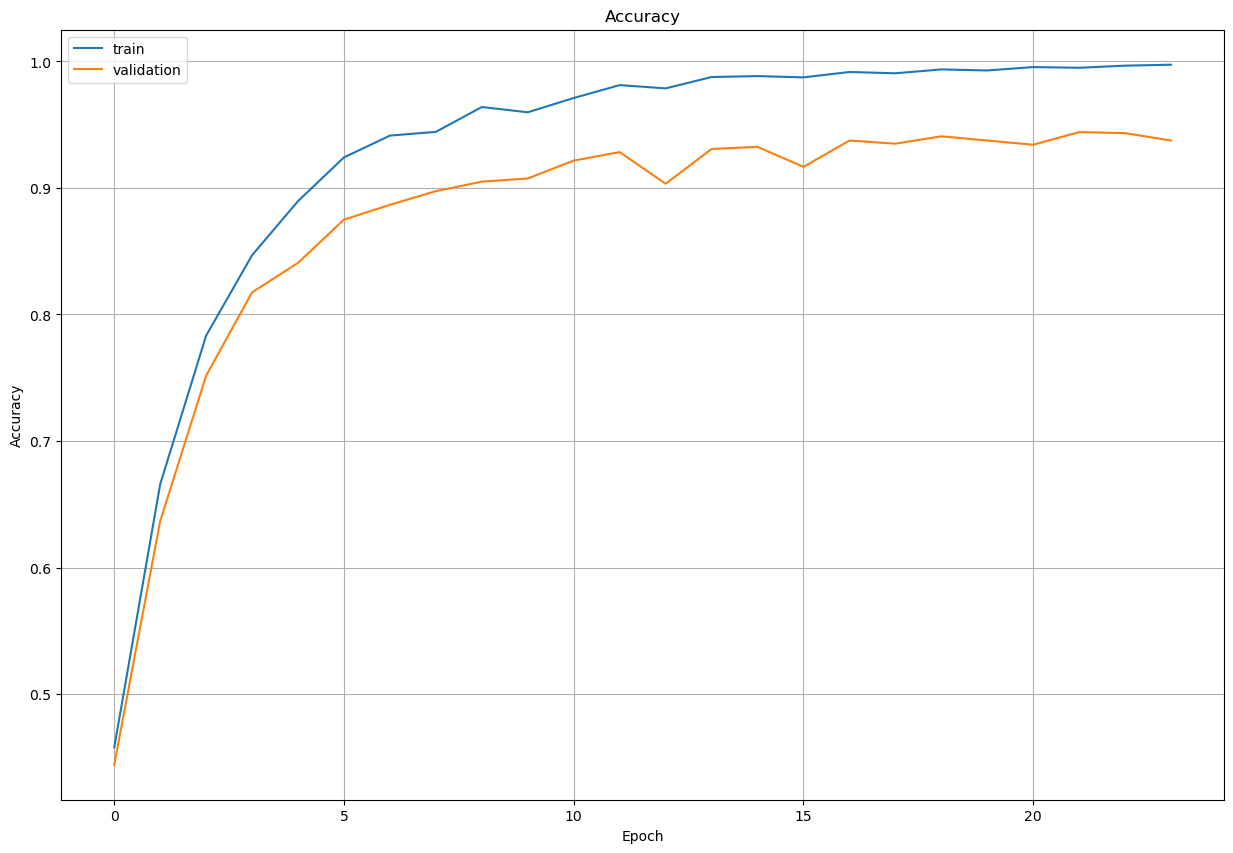

In [47]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(15, 10))

# # Plot the loss function
# plt.subplot(1, 2, 1)
# plt.plot(range(epochs), loss, label='train')
# plt.plot(range(epochs), loss, label='validation')
# plt.title('Loss Function')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.legend()

# # Plot the accuracy
# plt.subplot(1, 2, 2)
plt.plot(range(epochs), pt_hist['accuracy'], label='train')
plt.plot(range(epochs), pt_hist['val accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()


In [49]:
_ = check_accuracy(test_loader, pt_model)

Got 2827 / 3000 with accuracy 94.23333333333333%


In [45]:
loss

tensor(0.0183, grad_fn=<NllLossBackward0>)

## 6. Transfer Learning with Pytorch

In [59]:
# freeze the convolutional part

# iterate the model params
for param in pt_model.parameters():
    print(param.shape)
    break # only the first, the conv
    
# the printed shape is torch.Size([32, 1, 5, 5])
# are 32 outs and a 5x5 kernel of 1 chanel, so that
# are the params of the convolutional part

# that property is like "if the param is trainable"
if param.requires_grad == True:
    # set as not trainable param
    param.requires_grad = False

torch.Size([32, 1, 5, 5])


In [60]:
# check if it has the correct effect
for param in pt_model.parameters():
    print(param.shape)
    print(param.requires_grad)
    break

torch.Size([32, 1, 5, 5])
False


In [61]:
# restart the dense layer
# this is like "undo the train"

# redefine the layers
pt_model.dense1 = nn.Linear(32*30*30, 256)
pt_model.dense2 = nn.Linear(256, 256)
pt_model.dense3 = nn.Linear(256, 256)
pt_model.dense4 = nn.Linear(256, 15)

# move the model to the device
pt_model = pt_model.to(device)

In [62]:
# redefine the optimizer for the new parameters

# this optimizer receives the model trainable weights and a learning rate
new_optimizer = optim.Adam(filter(lambda p: p.requires_grad, pt_model.parameters()), lr=0.001)

In [63]:
# train variables
epochs = 24
pt_hist = {
    'accuracy': [],
    'val accuracy': [],
    'loss': []
}

# train the network
for epoch in range(epochs):
    # this iters the the data and targets, and with an id
    # data and targets are the batch for each train step
    for batch_idx, (data, targets) in enumerate(train_loader):
        # move the data and taregets to the model's device
        data = data.to(device)
        targets = targets.to(device)

        # forward propagation, predict and measure the error
        scores = pt_model(data)
        loss = criterion(scores, targets)
        
        # backward propagation, use the error to fit the weights
        new_optimizer.zero_grad() # clean the gradient, it's needed
        # contains the directions to redice the error value of
        # each prediction made, else is going to be adding value and fail
        ## back propagation of the gradient and fit the weights
        loss.backward()

        # gradient descent or adam step
        new_optimizer.step()
        
    print(f'==> Epoch{epoch}')
    # check the accuracy from train and val in each epoch
    acc = check_accuracy(train_loader, pt_model)
    val_acc = check_accuracy(val_loader, pt_model)
    
    # regist the accuacy values
    pt_hist['accuracy'].append(acc)
    pt_hist['val accuracy'].append(val_acc)
    pt_hist['loss'].append(loss.item())

==> Epoch0
Got 9358 / 10800 with accuracy 86.64814814814815%
Got 1006 / 1200 with accuracy 83.83333333333334%
==> Epoch1
Got 10215 / 10800 with accuracy 94.58333333333333%
Got 1091 / 1200 with accuracy 90.91666666666667%
==> Epoch2
Got 10246 / 10800 with accuracy 94.87037037037037%
Got 1091 / 1200 with accuracy 90.91666666666667%
==> Epoch3
Got 10556 / 10800 with accuracy 97.74074074074073%
Got 1115 / 1200 with accuracy 92.91666666666667%
==> Epoch4
Got 10672 / 10800 with accuracy 98.81481481481481%
Got 1116 / 1200 with accuracy 93.0%
==> Epoch5
Got 10701 / 10800 with accuracy 99.08333333333333%
Got 1115 / 1200 with accuracy 92.91666666666667%
==> Epoch6
Got 10725 / 10800 with accuracy 99.30555555555556%
Got 1128 / 1200 with accuracy 94.0%
==> Epoch7
Got 10667 / 10800 with accuracy 98.76851851851852%
Got 1116 / 1200 with accuracy 93.0%
==> Epoch8
Got 10768 / 10800 with accuracy 99.70370370370371%
Got 1132 / 1200 with accuracy 94.33333333333334%
==> Epoch9
Got 10753 / 10800 with accurac

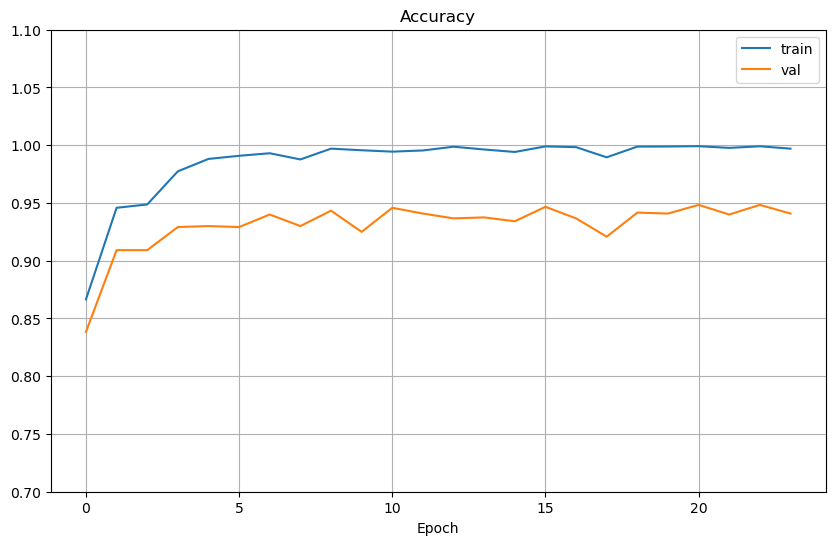

In [64]:
# plot the accuracy increase
x = np.arange(len(pt_hist['accuracy']))
plt.figure(figsize=(10,6))
plt.plot(x, pt_hist['accuracy'], label='train')
plt.plot(x, pt_hist['val accuracy'], label='val')
plt.title('Accuracy')
plt.grid(True)
plt.legend()
plt.ylim(.7,1.1)
plt.xlabel('Epoch')
plt.show()

### Evaluate Models

In [48]:
results = keras_model.evaluate(x_test_k, y_test_k, batch_size=64)
print("test loss, test acc:", results)

47/47 [==============================] - 1s 19ms/step - loss: 0.1889 - accuracy: 0.9550
test loss, test acc: [0.18894129991531372, 0.9549999833106995]


In [65]:
_ = check_accuracy(test_loader, pt_model)

Got 2838 / 3000 with accuracy 94.6%


## 7. Ensemble Two Models

In [50]:
# see the shapes of the predictions and how to predict
pt_model.eval()
pt_sample = torch.unsqueeze(test_set[0][0], 0).to(device)
pt_model(pt_sample).shape, type(pt_sample) == torch.Tensor, pt_sample.to('cpu').numpy().shape

(torch.Size([1, 15]), True, (1, 1, 64, 64))

In [51]:
ks_sample = x_test_k[0].reshape(1,64,64,1)
keras_model.predict(ks_sample).shape, type(ks_sample) == np.ndarray, ks_sample.shape

1/1 [==============================] - 0s 77ms/step


((1, 15), True, (1, 64, 64, 1))

In [53]:
class Ensemble:
    # models = [(model, 'keras' or 'pytorch')]
    # datasets = [(test_loader, 'pt_loader'), ((x_test_k, y_test_k), 'numpy')]
    def __init__(self, models=[], datasets=[]):
        self.models = []
        self.mtypes = []
        self.sets = datasets

        # read the models and the model types
        for model, mtype in models:
            self.models.append(model)
            self.mtypes.append(mtype)  
        
    def add_model(self, model, mtype):
        self.models.append(model)
        self.mtypes.append(mtype)
    
    def add_set(self, dataset, datatype):
        self.sets.append((dataset, datatype))
    
    # extra function to decode from one hot to numbers
    def decode(self, x): # recieve a torch tensor, a prediction
        # select the indexs of the max elements in each label
        x = torch.tensor(x)
        decoded = torch.argmax(x, dim=1).numpy()
        return decoded
    
    def predict(self, x):        
        # create a x for each mtype 
        x_dic = {}
        if type(x) == np.ndarray:
            x_dic['keras'] = x                     # keep the batch dim
            x_dic['pytorch'] = torch.from_numpy(x).to(device).view(x.shape[0], 1, 64, 64)
        else:
            x_dic['pytorch'] = x.to(device)
            x_dic['keras'] = x.to('cpu').numpy().reshape(x.shape[0], 64, 64, 1)
        
        # predict with the models
        preds = []
        for model, mtype in zip(self.models, self.mtypes):
            if mtype == 'keras':
                p = np.squeeze(model.predict(x_dic['keras']))
                preds.append(p)
            else:
                with torch.no_grad():
                    p = model(x_dic['pytorch']).to('cpu')
                    p = np.squeeze(p.detach().numpy())
                    preds.append(p)
        
        # sum the preds and obtain the mean
        sum_preds = sum(preds)/len(self.models)
        # reshape for the decode
        sum_preds = sum_preds.reshape(-1, 15)
        # return the decoded labels
        return self.decode(sum_preds)
    
    def evaluate(self):
        num_correct = 0
        num_samples = 0
        preds, answers = [], []
        for ds, datatype in self.sets:
            print('evaluation on -> ' + datatype)
            if datatype == 'numpy': # there are x_test and x_train
                x_set, y_set = ds
                y_set = self.decode(y_set)
                for x, y in zip(x_set, y_set):
                    # predict each image with both models
                    pred = self.predict(x.reshape(1, 64, 64, 1))[0]
                    # append the predictions and the answers
                    preds.append(pred)
                    answers.append(y)
                    # count the answers
                    if pred == y:
                        num_correct += 1
                    num_samples += 1
                    
            elif datatype == 'pt_loader': # the pytorch loader
                for batch_x, batch_y in ds: # this will return a batch
                    for x, y in zip(batch_x, batch_y):
                        # predict each image with both models
                        pred = self.predict(x.view(1, 1, 64, 64))[0]
                        # append the predictions and the answers
                        preds.append(pred)
                        answers.append(y)
                        # count the answers
                        if pred == y.item():
                            num_correct += 1
                        num_samples += 1
        
        return num_correct/num_samples, answers, preds
                    
    

model = Ensemble(
    models = [(keras_model, 'keras'), (pt_model, 'pytorch')],
    datasets = [((x_test_k, y_test_k), 'numpy'), (test_loader, 'pt_loader')]
)

# it will take a while
acc, predictions, answers = model.evaluate()
acc

evaluation on -> numpy
1/1 [==============================] - 0s 14ms/step
evaluation on -> pt_loader
1/1 [==============================] - 0s 15ms/step


0.9513333333333334

## 8. Ensemble Model Performance

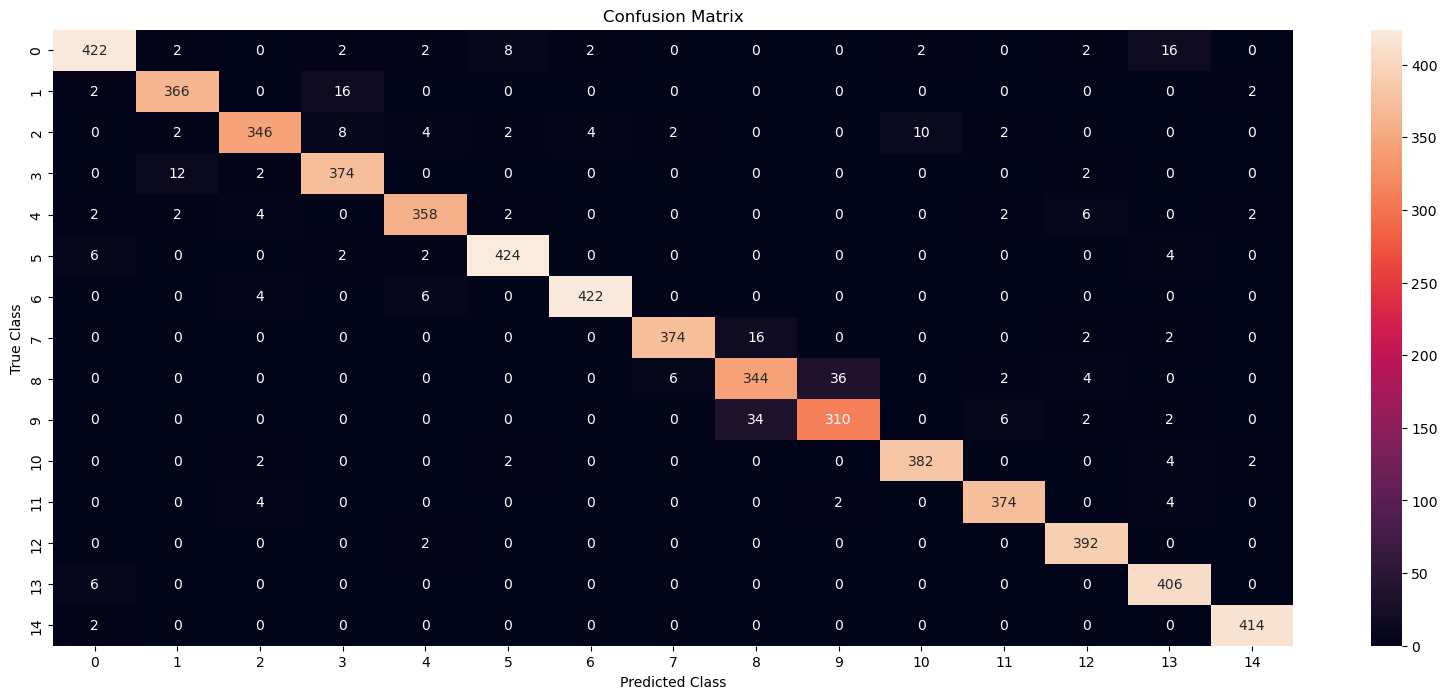

Labels and ids:
dict_keys(['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六', '七', '八'])
dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])


In [54]:
# define the matrix with the real classes and the predicted
m = confusion_matrix(answers, predictions)
# the labels for the plot
labels = list(class_names.values()) # the characters throw warnings
plt.figure(figsize=(20, 8))
# create the plot
heatmap = sns.heatmap(m, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', color='blue')
# labels for the axes
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()
# print the ids and the labels
print('Labels and ids:')
print(test_set.id_labels.keys())
print(test_set.id_labels.values())

1/1 [==============================] - 0s 28ms/step


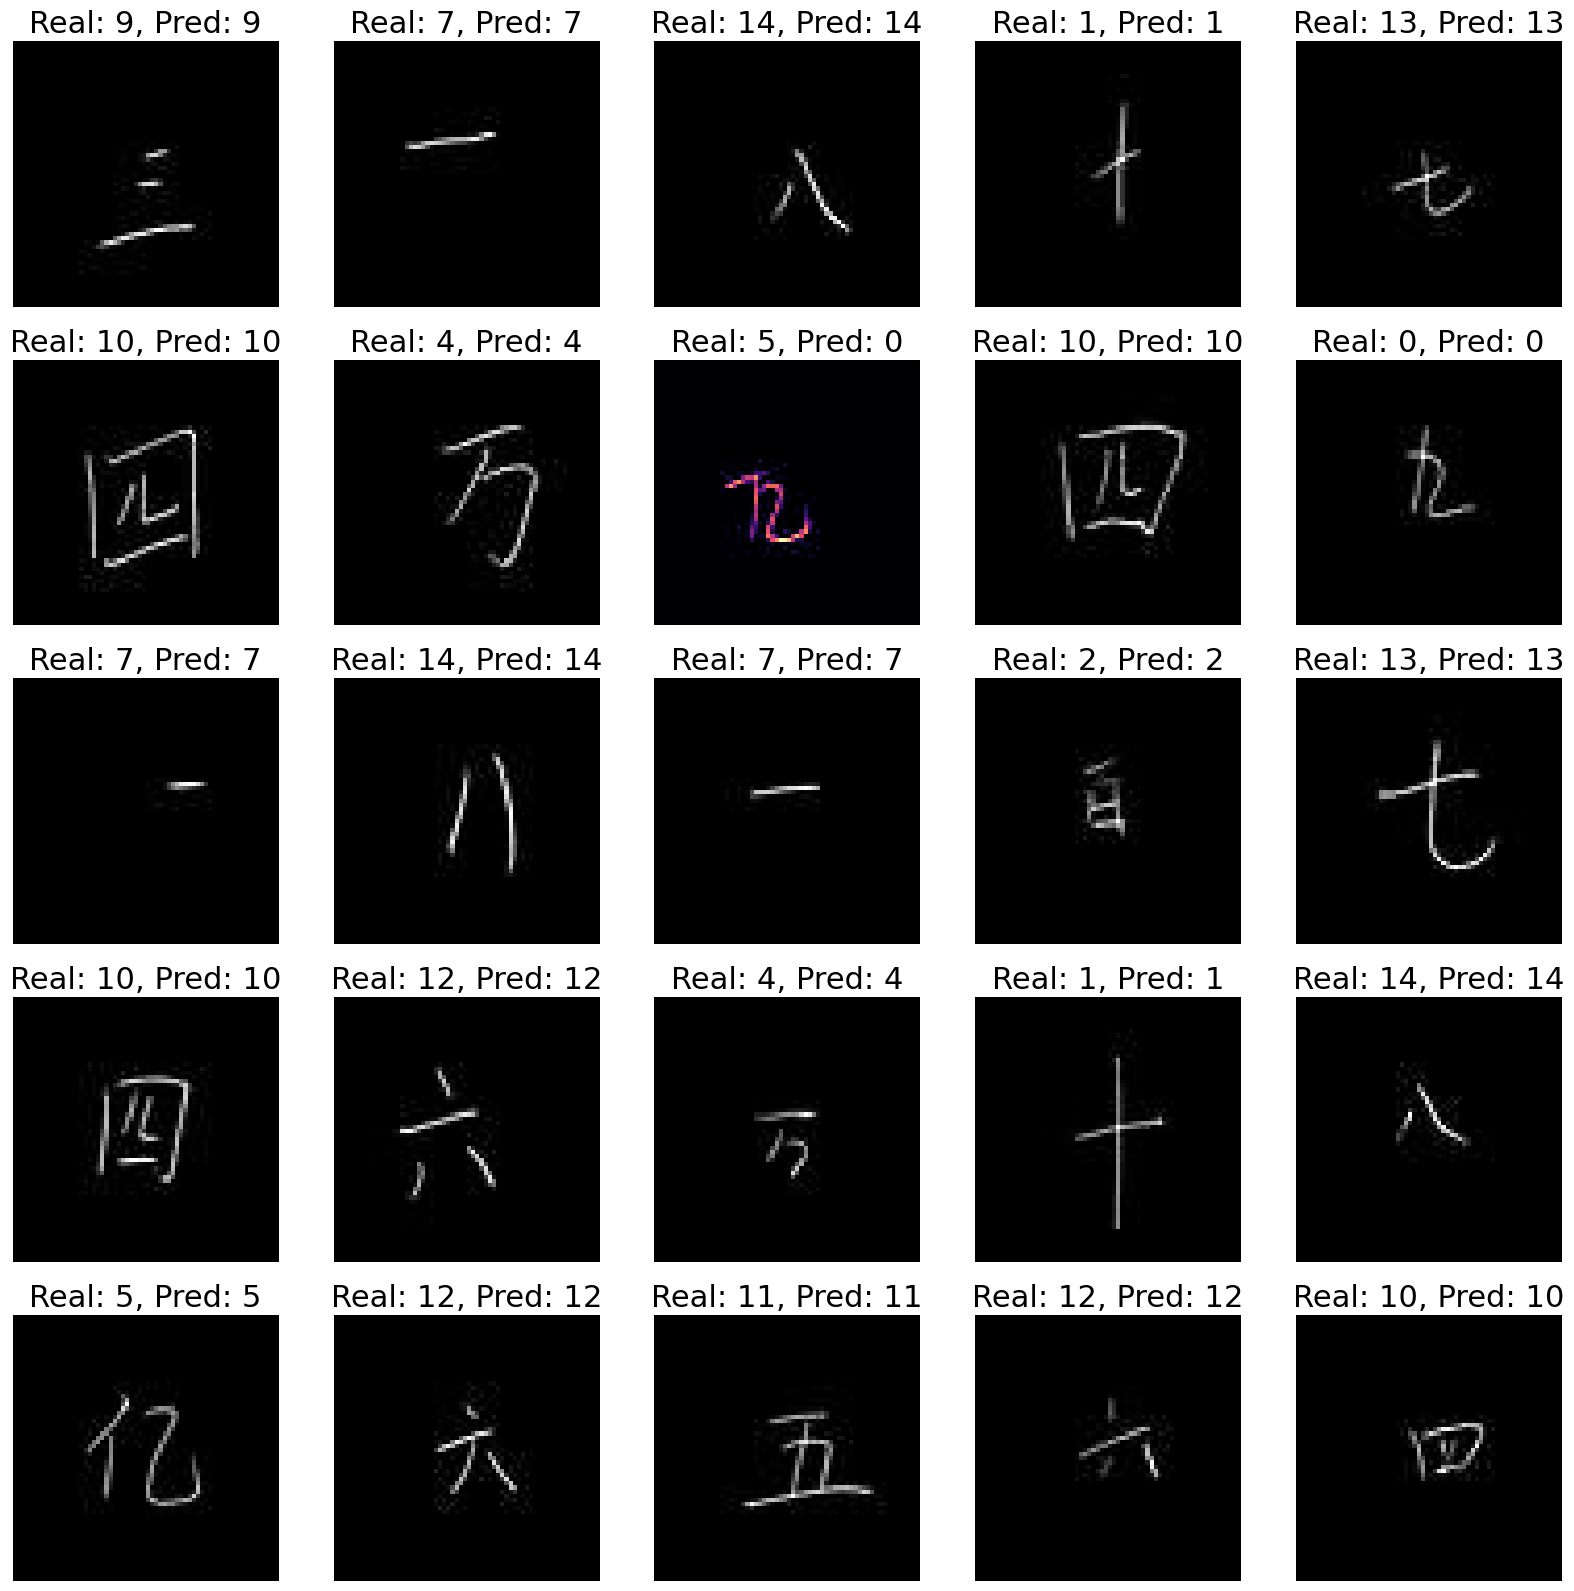

In [57]:
# prediction
# preds must be like [[real, pred]]
def plot_images(imgs, dims, figsize, title_size, preds=[]):
    plt.figure(figsize=figsize)
    for img, i, in zip(imgs, np.arange(imgs.shape[0])):
        plt.subplot(dims[0], dims[1], i+1)
        # plot in a different color if the prediction is wrong
        plt.imshow(np.squeeze(img), cmap=('gray' if preds[i][1] == preds[i][0] else 'magma'))
        plt.axis('off')
        title = f'Image {i+1}'
        if preds != []:
            title = f'Real: {preds[i][0]}, Pred: {preds[i][1]}'
        plt.title(title, fontsize=title_size)
    plt.show()

# select some images
sample_images = x_test_k[:25]
predicts = model.predict(sample_images)
answers = model.decode(y_test_k[:25])

# the preds and answers for the plot
data = []
for p,a in zip(predicts, answers):
    data.append((a,p))
    
plot_images(sample_images, dims=(5,5), figsize=(20,20), title_size=22, preds=data)